<a href="https://colab.research.google.com/github/crisalex25/TFM/blob/main/TFM_Algoritmos_predicci%C3%B3n_Demanda_de_Energ%C3%ADa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabajo de Fin de Master**
## **Máster Universitario en Inteligencia Artificial para el Sector de la Energía y las Infraestructuras**
Optimización de generación en centrales hidroeléctricas mediante técnicas de aprendizaje automático

###Librerias

In [ ]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

###Leer Dataset

In [ ]:
AC="https://raw.githubusercontent.com/crisalex25/TFM/main/AC3.csv"
GC="https://raw.githubusercontent.com/crisalex25/TFM/main/GC3.csv"

In [ ]:
dfAC = pd.read_csv(AC, sep=';', decimal=",", parse_dates=['Fecha_Hora'])
dfGC = pd.read_csv(GC, sep=';', decimal=",", parse_dates=['Fecha_Hora'])

fecha_limite = datetime(2023, 1, 1, 0, 0)  # Fecha límite

dfAC = dfAC[dfAC['Fecha_Hora'] <= fecha_limite]
dfGC = dfGC[dfGC['Fecha_Hora'] <= fecha_limite]

##Modelos de predicción Demanda Energía

####Modelo Red neuronal LSTM (memoria a corto plazo)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

def train_lstm_model(df, sequence_length=24, epochs=20, batch_size=16, validation_split=0.2, patience=3):
    # Extraer la columna de demanda de energía
    demand_data = df['valor'].values

    # Normalizar los datos
    scaler = MinMaxScaler(feature_range=(0, 1))
    demand_data_normalized = scaler.fit_transform(demand_data.reshape(-1, 1))

    # Dividir los datos en conjuntos de entrenamiento y prueba
    train_size = int(len(demand_data_normalized) * (1 - validation_split))
    train_data, test_data = demand_data_normalized[:train_size], demand_data_normalized[train_size:]

    # Crear secuencias de entrada y salida para el entrenamiento de la red neuronal
    def create_sequences(data, seq_length):
        X = []
        y = []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(train_data, sequence_length)
    X_test, y_test = create_sequences(test_data, sequence_length)

    # Crear el modelo de red neuronal
    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(sequence_length, 1), return_sequences=True))
    model.add(LSTM(16, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=Adam(), loss='MSE', metrics=["mae","mse"])
    model.summary()

    # Entrenar el modelo
    early_stopping = EarlyStopping(patience=patience)  # Detener el entrenamiento si no hay mejora en el número de épocas especificado
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)

    # Desnormalizar los datos de predicción
    y_pred_denormalized = scaler.inverse_transform(y_pred)
    y_test_denormalized = scaler.inverse_transform(y_test.reshape(-1, 1))

    return y_pred_denormalized, y_test_denormalized, train_size


####Modelo Red neuronal MLP

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def train_dense_model(df, sequence_length=24, epochs=20, batch_size=16, validation_split=0.2, patience=3):
    # Extraer la columna de demanda de energía
    demand_data = df['valor'].values

    # Normalizar los datos
    scaler = MinMaxScaler(feature_range=(0, 1))
    demand_data_normalized = scaler.fit_transform(demand_data.reshape(-1, 1))

    # Dividir los datos en conjuntos de entrenamiento y prueba
    train_size = int(len(demand_data_normalized) * (1 - validation_split))
    train_data, test_data = demand_data_normalized[:train_size], demand_data_normalized[train_size:]

    # Crear secuencias de entrada y salida para el entrenamiento de la red neuronal
    def create_sequences(data, seq_length):
        X = []
        y = []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(train_data, sequence_length)
    X_test, y_test = create_sequences(test_data, sequence_length)

    # Crear el modelo de red neuronal
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(sequence_length,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=["mae","mse"])
    model.summary()

    # Entrenar el modelo
    early_stopping = EarlyStopping(patience=patience)  # Detener el entrenamiento si no hay mejora en el número de épocas especificado
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)

    # Desnormalizar los datos de predicción y los valores reales
    y_pred_denormalized = scaler.inverse_transform(y_pred)
    y_test_denormalized = scaler.inverse_transform(y_test.reshape(-1, 1))

    return y_pred_denormalized, y_test_denormalized, train_size


### Prediccion Autoconsumos

####LSTM AutoConsumo

In [ ]:
y_pred_denormalized, y_test_denormalized, train_size = train_lstm_model(dfAC)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1786/1786 [==============================] - 51s 25ms/step - loss: 0.0113 - mae: 0.0521 - mse: 0.0113 - val_loss: 0.0016 - val_mae: 0.0266 - val_mse: 0.0016
Epoch 2/20
1786/1786 [==============================] - 47s 27ms/step - loss: 0.0013 - mae: 0.0241 - mse: 0.0013 - val_loss: 0.0010 - val_mae: 0.0207 

In [ ]:
dfAC.head()

,Fecha_Hora,valor
0,2019-01-01 01:00:00,1469.118
1,2019-01-01 02:00:00,1463.080
2,2019-01-01 03:00:00,1472.200
3,2019-01-01 04:00:00,1457.208
4,2019-01-01 05:00:00,1462.482


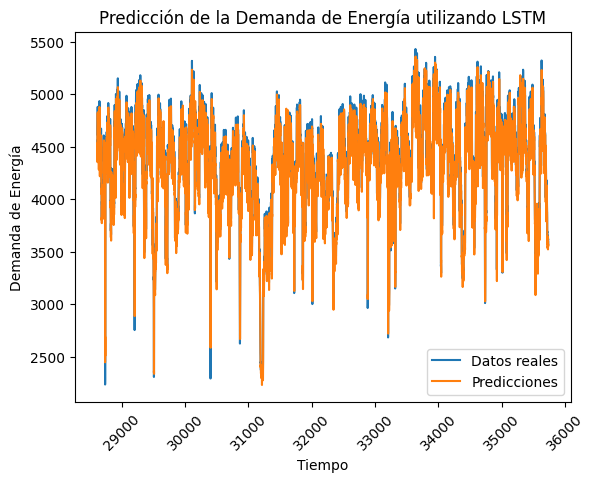

In [ ]:
# Establecer la columna 'Fecha_Hora' como el índice del DataFrame
#dfAC.set_index('Fecha_Hora', inplace=True)

# Obtener las fechas correspondientes al conjunto de prueba
sequence_length=24
fechas_test = dfAC.index[train_size + sequence_length:]

# Visualizar los resultados
plt.plot(fechas_test, y_test_denormalized, label='Datos reales')
plt.plot(fechas_test, y_pred_denormalized, label='Predicciones')
plt.xlabel('Tiempo')
plt.ylabel('Demanda de Energía')
plt.title('Predicción de la Demanda de Energía utilizando LSTM')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calcular el error absoluto medio (MAE) y el error cuadrático medio (MSE)
mae = mean_absolute_error(y_test_denormalized, y_pred_denormalized)
mse = mean_squared_error(y_test_denormalized, y_pred_denormalized)
r2 = r2_score(y_test_denormalized, y_pred_denormalized)

print('Error absoluto medio (MAE):', mae)
print('Error cuadrático medio (MSE):', mse)
print('Coeficiente de determinación (R^2):', r2)


Error absoluto medio (MAE): 98.55154832915144
Error cuadrático medio (MSE): 20689.09999749759
Coeficiente de determinación (R^2): 0.8980972006217359


####Red Neuronal Autoconsumo

In [ ]:
y_pred_denormalized, y_test_denormalized, train_size = train_dense_model(dfAC)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               3200      
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,569
Trainable params: 13,569
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1786/1786 [==============================] - 6s 3ms/step - loss: 0.0021 - mae: 0.0285 - mse: 0.0021 - val_loss: 0.0015 - val_mae: 0.0292 - val_mse: 0.0015
Epoch 2/20
1786/

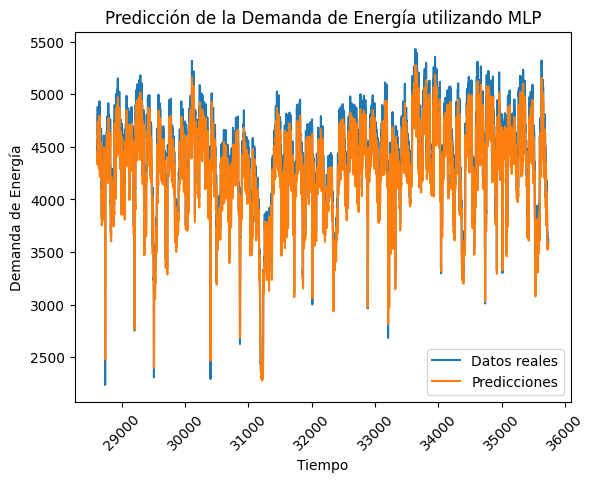

In [ ]:
# Establecer la columna 'Fecha_Hora' como el índice del DataFrame
#dfAC.set_index('Fecha_Hora', inplace=True)

# Obtener las fechas correspondientes al conjunto de prueba
sequence_length=24
fechas_test = dfAC.index[train_size + sequence_length:]

# Visualizar los resultados
plt.plot(fechas_test, y_test_denormalized, label='Datos reales')
plt.plot(fechas_test, y_pred_denormalized, label='Predicciones')
plt.xlabel('Tiempo')
plt.ylabel('Demanda de Energía')
plt.title('Predicción de la Demanda de Energía utilizando MLP')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calcular el error absoluto medio (MAE) y el error cuadrático medio (MSE)
mae = mean_absolute_error(y_test_denormalized, y_pred_denormalized)
mse = mean_squared_error(y_test_denormalized, y_pred_denormalized)
r2 = r2_score(y_test_denormalized, y_pred_denormalized)

print('Error absoluto medio (MAE):', mae)
print('Error cuadrático medio (MSE):', mse)
print('Coeficiente de determinación (R^2):', r2)

Error absoluto medio (MAE): 128.24340176472137
Error cuadrático medio (MSE): 28374.09487911326
Coeficiente de determinación (R^2): 0.8602452644940654


###Prediccion Gran Consumidor

####Red neuronal LSTM 1 Granconsumidor


In [ ]:
y_pred_denormalized, y_test_denormalized, train_size = train_lstm_model(dfGC)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 24, 32)            4352      
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1348/1348 [==============================] - 39s 26ms/step - loss: 0.0078 - mae: 0.0460 - mse: 0.0078 - val_loss: 0.0014 - val_mae: 0.0273 - val_mse: 0.0014
Epoch 2/20
1348/1348 [==============================] - 34s 25ms/step - loss: 0.0019 - mae: 0.0290 - mse: 0.0019 - val_loss: 0.0011 - val_mae: 0.024

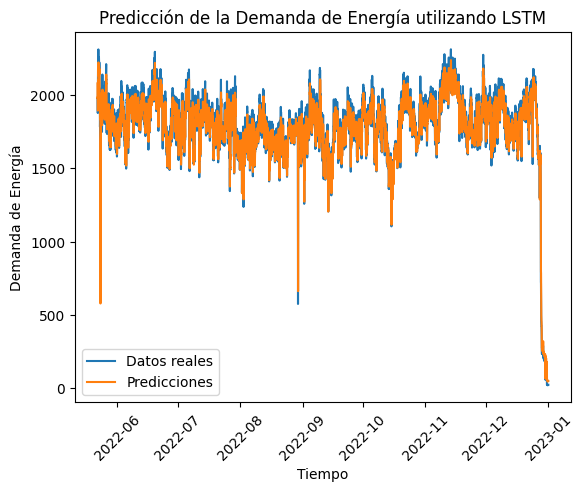

In [ ]:
dfGC.set_index('Fecha_Hora', inplace=True)

# Obtener las fechas correspondientes al conjunto de prueba
sequence_length=24
fechas_test = dfGC.index[train_size + sequence_length:]

# Visualizar los resultados
plt.plot(fechas_test, y_test_denormalized, label='Datos reales')
plt.plot(fechas_test, y_pred_denormalized, label='Predicciones')
plt.xlabel('Tiempo')
plt.ylabel('Demanda de Energía')
plt.title('Predicción de la Demanda de Energía utilizando LSTM')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calcular el error absoluto medio (MAE) y el error cuadrático medio (MSE)
mae = mean_absolute_error(y_test_denormalized, y_pred_denormalized)
mse = mean_squared_error(y_test_denormalized, y_pred_denormalized)
r2 = r2_score(y_test_denormalized, y_pred_denormalized)

print('Error absoluto medio (MAE):', mae)
print('Error cuadrático medio (MSE):', mse)
print('Coeficiente de determinación (R^2):', r2)



Error absoluto medio (MAE): 55.40435351131323
Error cuadrático medio (MSE): 5708.3854216225745
Coeficiente de determinación (R^2): 0.9202443720557328


####Red Neuronal 1 GranConsumidor

In [ ]:
y_pred_denormalized, y_test_denormalized, train_size = train_dense_model(dfGC)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               3200      
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,569
Trainable params: 13,569
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1348/1348 [==============================] - 5s 3ms/step - loss: 0.0026 - mae: 0.0314 - mse: 0.0026 - val_loss: 0.0010 - val_mae: 0.0230 - val_mse: 0.0010
Epoch 2/20
1348/

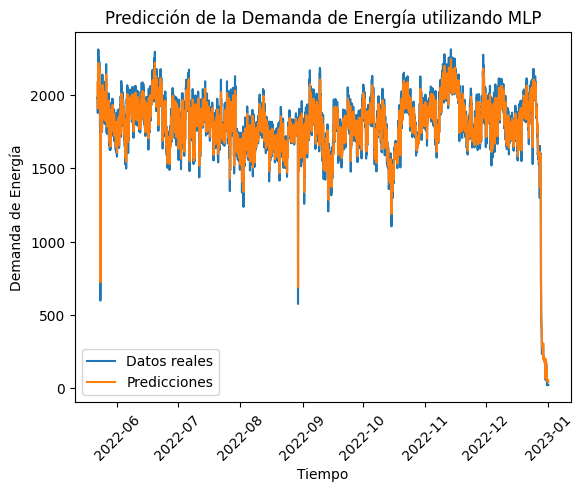

In [ ]:
#dfGC.set_index('Fecha_Hora', inplace=True)

# Obtener las fechas correspondientes al conjunto de prueba
sequence_length=24
fechas_test = dfGC.index[train_size + sequence_length:]

# Visualizar los resultados
plt.plot(fechas_test, y_test_denormalized, label='Datos reales')
plt.plot(fechas_test, y_pred_denormalized, label='Predicciones')
plt.xlabel('Tiempo')
plt.ylabel('Demanda de Energía')
plt.title('Predicción de la Demanda de Energía utilizando MLP')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calcular el error absoluto medio (MAE) y el error cuadrático medio (MSE)
mae = mean_absolute_error(y_test_denormalized, y_pred_denormalized)
mse = mean_squared_error(y_test_denormalized, y_pred_denormalized)
r2 = r2_score(y_test_denormalized, y_pred_denormalized)

print('Error absoluto medio (MAE):', mae)
print('Error cuadrático medio (MSE):', mse)
print('Coeficiente de determinación (R^2):', r2)

Error absoluto medio (MAE): 54.111104505066
Error cuadrático medio (MSE): 5575.188461799053
Coeficiente de determinación (R^2): 0.9221053548707251
